In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from tensorflow_probability.python.math.psd_kernels.internal import util
from typing import List

# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'


In [2]:
np.random.seed(20)


# Multi-Fidelity GP using Two GPs using tensorflow

Use the multi-fidelity example in the emukit


In [3]:
# original code
#  https://github.com/EmuKit/emukit/blob/main/emukit/test_functions/forrester.py

def forrester(x, sd=0):
    """
    Forrester function
    :param x: input vector to be evaluated
    :param sd: standard deviation of noise parameter
    :return: outputs of the function
    """
    x = x.reshape((len(x), 1))
    n = x.shape[0]
    fval = ((6 * x - 2) ** 2) * np.sin(12 * x - 4)
    if sd == 0:
        noise = np.zeros(n).reshape(n, 1)
    else:
        noise = np.random.normal(0, sd, n).reshape(n, 1)
    return fval.reshape(n, 1) + noise


def forrester_low(x, sd=0):
    """
    Low fidelity forrester function approximation:
    :param x: input vector to be evaluated
    :param sd: standard deviation of observation noise at low fidelity
    :return: outputs of the function
    """
    high_fidelity = forrester(x, 0)
    return 0.5 * high_fidelity + 10 * (x[:, [0]] - 0.5) + 5 + np.random.randn(x.shape[0], 1) * sd

In [4]:
high_fidelity = forrester
low_fidelity  = forrester_low

x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = np.atleast_2d(np.random.rand(40)).T
x_train_h = np.atleast_2d(np.random.permutation(x_train_l)[:6])
y_train_l = low_fidelity(x_train_l)
y_train_h = high_fidelity(x_train_h)


More HF training points than the LF training points.

In [5]:
x_train_h.shape, x_train_l.shape

((6, 1), (40, 1))

In [6]:
y_train_h.shape, y_train_l.shape

((6, 1), (40, 1))

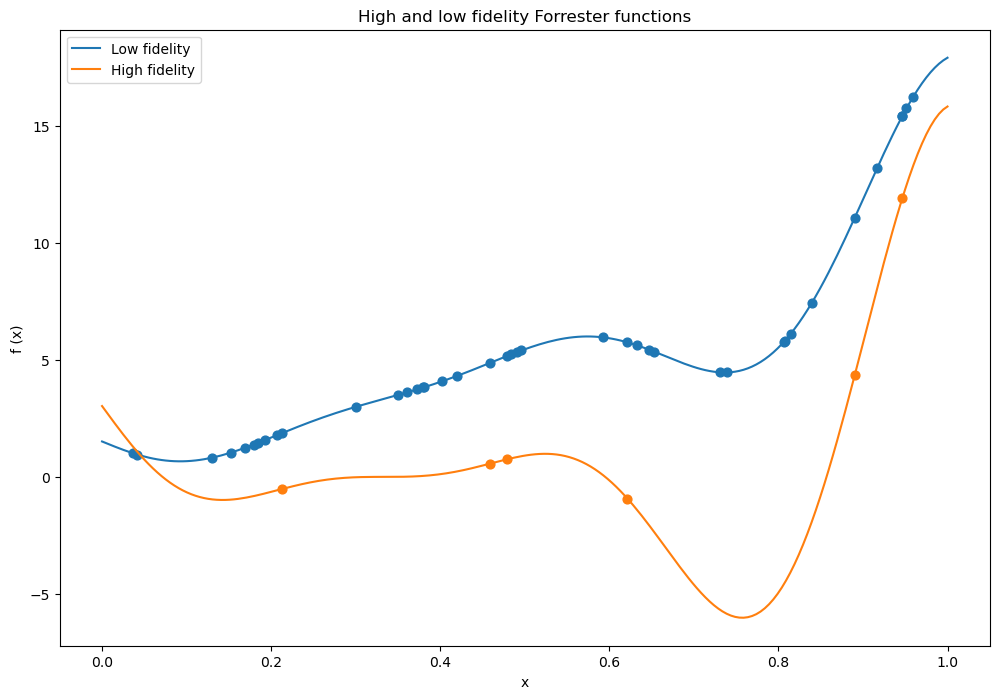

In [7]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, 'C0')
plt.plot(x_plot, y_plot_h, 'C1')
plt.scatter(x_train_l, y_train_l, color='C0', s=40)
plt.scatter(x_train_h, y_train_h, color='C1', s=40)
plt.ylabel('f (x)')
plt.xlabel('x')
plt.legend(['Low fidelity', 'High fidelity'])
plt.title('High and low fidelity Forrester functions');


## Multi-fidelity with Linear scale kernel

We could define a new kernel class to incorporate two kernels

In [8]:
class InputTransformedKernel(tfk.PositiveSemidefiniteKernel):

  def __init__(self, kernel, transformation, name='InputTransformedKernel'):
    self._kernel = kernel
    self._transformation = transformation
    super(InputTransformedKernel, self).__init__(
        feature_ndims=kernel.feature_ndims,
        dtype=kernel.dtype,
        name=name)

  def apply(self, x1, x2):
    return self._kernel.apply(
        self._transformation(x1),
        self._transformation(x2))

  def matrix(self, x1, x2):
    return self._kernel.matrix(
        self._transformation(x1),
        self._transformation(x2))

  @property
  def batch_shape(self):
    return self._kernel.batch_shape

  def batch_shape_tensor(self):
    return self._kernel.batch_shape_tensor

class InputScaledKernel(InputTransformedKernel):

  def __init__(self, kernel, length_scales):
    super(InputScaledKernel, self).__init__(
        kernel,
        lambda x: x / tf.expand_dims(length_scales,
                                     -(kernel.feature_ndims + 1)))


In [9]:
class LinearMultiFidelityKernel(tfk.PositiveSemidefiniteKernel):

    """
        Fidelity s is modelled as:
        f_s(x) = p_t * f_t(x) + d_s(x)

        where:
        s is the fidelity
        t is the previous fidelity
        f_s(x) is the function modelling fidelity s
        d_s(x) models the difference between fidelity s-1 and s
        p_t a scaling parameter between fidelity t and s

    TODO: Now only assume two fidelities, so

        Fidelity s is modelled as:
        f_2(x) = p_1 * f_1(x) + d_2(x)

    """
    def __init__(self, kernel_list: List, scale_parameter_list: List, name='LinearMultiFidelityKernel'):
        # Now only assume two fidelities
        # TODO: this part needs update to more fidelities. Though in general I think
        #       it is not quite useful in the scale of n_fidelities > 2 unless it is
        #       marginalizing over fidelities.
        self._kernel_0 = kernel_list[0] # HF
        self._kernel_1 = kernel_list[1] # LF
        # for the batch_shape, use the HF kernel
        self._kernel = kernel_list[0]

        self._scale_parameter = scale_parameter_list[0]

        super(LinearMultiFidelityKernel, self).__init__(
            feature_ndims=self._kernel.feature_ndims,
            dtype=self._kernel.dtype,
            name=name)

    def _apply(self, x1, x2, example_ndims=0):
        k_hf = self._kernel_0.apply(x1, x2, example_ndims) # important!! Need to pass example_ndims
        k_lf = self._kernel_1.apply(x1, x2, example_ndims) # otherwise the passing batches won't work

        # here is just broadcasting this rho to all batches
        # in principle you might make it to be batch dependent
        # (so that different scale for different outputs, in case
        # of vector outputs)
        rho = self._scale_parameter

        rho = tf.convert_to_tensor(rho)
        rho = util.pad_shape_with_ones(rho, example_ndims)


        # import pdb
        # pdb.set_trace()

        return k_hf + k_lf * rho ** 2

    # def matrix(self, x1, x2):
    #     kk_hf = self._kernel_0.matrix(x1, x2) 
    #     kk_lf = self._kernel_1.matrix(x1, x2) 

    #     rho = self._scale_parameter

    #     return kk_hf + kk_lf * rho ** 2

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor


My design here is to build two GPs, while the HF one is coupled with the LF one. The learnable parameters are shared between the GPs. The scale parameter for the correlation should be placed in the kernel.

```

1st GP:
---
X_LF -> GP_LF -> Y_LF

2nd GP:
---
X_HF -> GP_LF -> f_LF  
X_HF -> GP_HF -> delta_HF  
              -> f_LF * rho + delta_HF
```

In [10]:
def build_gp_lf(
      amplitude,
      length_scale,
      observation_noise_variance
    ):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train_l,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )

def build_gp_hf(
      amplitude_0,     # HF
      length_scale_0,  # HF
      amplitude_1,     # LF
      length_scale_1,  # LF
      observation_noise_variance,
      scale_parameter
    ):
    """
    High-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    f_HF = \rho f_LF + \delta

      X_HF -> GP_LF -> f_LF  
      X_HF -> GP_HF -> delta_HF  
                  -> f_LF * rho + delta_HF
    """

    # HF kernel
    kernel_0 = tfk.ExponentiatedQuadratic(amplitude_0, length_scale_0)
    # LF kernel
    kernel_1 = tfk.ExponentiatedQuadratic(amplitude_1, length_scale_1)

    ar1_kernel = LinearMultiFidelityKernel(
      [kernel_0, kernel_1], [scale_parameter], name="AR1"
    )

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=ar1_kernel,
        index_points=x_train_h,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance
    )


gp_joint_model_lf = tfd.JointDistributionNamed({
  'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
  'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
  'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(0.05)),
  'observations': build_gp_lf,
})

gp_joint_model_hf = tfd.JointDistributionNamed({
  'amplitude_0': tfd.LogNormal(loc=0., scale=np.float64(1.)),
  'length_scale_0': tfd.LogNormal(loc=0., scale=np.float64(1.)),
  'amplitude_1': tfd.LogNormal(loc=0., scale=np.float64(1.)),
  'length_scale_1': tfd.LogNormal(loc=0., scale=np.float64(1.)),
  'scale_parameter': tfd.Normal(loc=1., scale=np.float64(0.5)),
  'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(0.05)),
  'observations': build_gp_hf,
})



In [11]:
# Test the batch shape
gp_joint_model_lf.batch_shape, gp_joint_model_hf.batch_shape

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


/Users/jibanmac/Documents/conda/tensorflow/lib/python3.9/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:501: FutureWarning: When the `always_yield_multivariate_normal` arg to `GaussianProcess.__init__` is ignored, after 2023-02-15, `get_marginal_distribution` will always return a Normal distribution with vector event shape. This is the current behavior when `always_yield_multivariate_normal=True`. To recover the behavior of `always_yield_multivariate_normal=False` when `index_points` contains a single index point, build a scalar `Normal` distribution as follows: `mvn = get_marginal_distribution(index_points); ``norm = tfd.Normal(mvn.loc[..., 0], scale=mvn.stddev()[..., 0])`. To suppress these warnings, build the `GaussianProcess` with `always_yield_multivariate_normal=True`.
  warnings.warn(


({'observation_noise_variance': TensorShape([]),
  'length_scale': TensorShape([]),
  'amplitude': TensorShape([]),
  'observations': TensorShape([])},
 {'scale_parameter': TensorShape([]),
  'observation_noise_variance': TensorShape([]),
  'length_scale_1': TensorShape([]),
  'length_scale_0': TensorShape([]),
  'amplitude_1': TensorShape([]),
  'amplitude_0': TensorShape([]),
  'observations': TensorShape([])})

Let's test if we can compute the log prob


In [12]:
x_l = gp_joint_model_lf.sample()
lp_l = gp_joint_model_lf.log_prob(x_l)

print("sampled {}".format(x_l))
print("log_prob of sample: {}".format(lp_l))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=1.0037637387878655>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.3168757198387682>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.3872379375935854>, 'observations': <tf.Tensor: shape=(40,), dtype=float64, numpy=
array([ 0.58696495, -0.50285792,  1.35900604,  1.31172208,  0.07395037,
       -0.81450991,  0.8010373 , -1.44666643, -0.31200322, -0.02016355,
        0.88949858,  1.53711292,  1.56929752, -0.96256993,  0.99062082,
        0.30059433, -0.61695428, -2.37964029, -0.04805876, -0.78573449,
        0.25888875, -0.74974386, -1.19832736,  0.60980751,  0.76060175,
        0.68448332, -0.28062422, -2.42551636, -1.0887065 ,  1.29063108,
       -0.25865197, -1.27828022, -1.67024098, -0.14041348, -1.53437589,
       -1.42258733, -1.4395606 , -1.10057483,  1.63795881, -0.64079383])>}
log_prob of sample: -59.27807849485443


In [13]:
x_h  = gp_joint_model_hf.sample()
lp_h = gp_joint_model_hf.log_prob(x_h)

print("sampled {}".format(x_h))
print("log_prob of sample: {}".format(lp_h))

sampled {'scale_parameter': <tf.Tensor: shape=(), dtype=float64, numpy=0.5548355522893336>, 'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=1.1741735868445282>, 'length_scale_1': <tf.Tensor: shape=(), dtype=float64, numpy=1.960264180767356>, 'length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.3108444418990775>, 'amplitude_1': <tf.Tensor: shape=(), dtype=float64, numpy=0.7695485262814069>, 'amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.7660479282203132>, 'observations': <tf.Tensor: shape=(6,), dtype=float64, numpy=
array([-1.93949637,  0.84981102, -1.61529102, -0.40906069, -1.65251781,
       -0.57007752])>}
log_prob of sample: -17.30866249581389


Set the learnable parameters and train based on the maximum marginal likelihoods of two GPs.

In [14]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
# jibancat: the scale parameter no needs to be positive, 
# but I guess it's okay to constrain it to be positive so the delta would 
# compensate the sign difference.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude_0',
    dtype=np.float64
)

length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale_0',
    dtype=np.float64
)

observation_noise_variance_var_0 = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var_0',
    dtype=np.float64
)


amplitude_var_1 = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude_1',
    dtype=np.float64
)

length_scale_var_1 = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale_1',
    dtype=np.float64
)

observation_noise_variance_var_1 = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var_1',
    dtype=np.float64
)

scale_parameter_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='scale_parameter_var',
    dtype=np.float64
)


# scale_parameter_var = tf.Variable(
#     1.,
#     name='scale_parameter_var',
#     dtype=np.float64,
# )

trainable_variables = [
    v.trainable_variables[0] for v in 
    [
        amplitude_var_0,
        length_scale_var_0,
        observation_noise_variance_var_0,
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
        scale_parameter_var
    ]
]
# trainable_variables.append(scale_parameter_var)

To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

We will combine the log likelihoods from both GP_LF and GP_HF to be one joint likelihood.

In [15]:
def target_log_prob(
    amplitude_0,
    length_scale_0,
    observation_noise_variance_0,
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
    scale_parameter,
):
    """
    Loglike(LF) + Loglike(HF)
    """

    log_prob_lf = gp_joint_model_lf.log_prob({
        'amplitude': amplitude_1,
        'length_scale': length_scale_1,
        'observation_noise_variance': observation_noise_variance_1,
        'observations': y_train_l[:, 0],
    })

    log_prob_hf = gp_joint_model_hf.log_prob({
        'amplitude_0': amplitude_0,
        'length_scale_0': length_scale_0,
        'amplitude_1': amplitude_1,
        'length_scale_1': length_scale_1,
        'observation_noise_variance': observation_noise_variance_0,
        'observations': y_train_h[:, 0],
        "scale_parameter": scale_parameter,
    })

    return tf.reduce_sum( [log_prob_hf, log_prob_lf ])


In [16]:
# Now we optimize the model parameters.
num_iters = 10000
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(
        amplitude_0=amplitude_var_0,
        length_scale_0=length_scale_var_0,
        amplitude_1=amplitude_var_1,
        length_scale_1=length_scale_var_1,
        observation_noise_variance_0=observation_noise_variance_var_0,
        observation_noise_variance_1=observation_noise_variance_var_1,
        scale_parameter=scale_parameter_var,
    )
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('Scale parameter:', scale_parameter_var)
print('LF amplitude: {}'.format(amplitude_var_1._value().numpy()))
print('LF length_scale: {}'.format(length_scale_var_1._value().numpy()))
print('LF observation_noise_variance: {}'.format(observation_noise_variance_var_1._value().numpy()))
print('HF amplitude: {}'.format(amplitude_var_0._value().numpy()))
print('HF length_scale: {}'.format(length_scale_var_0._value().numpy()))
print('HF observation_noise_variance: {}'.format(observation_noise_variance_var_0._value().numpy()))

2022-12-30 16:22:07.664671: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
Scale parameter: <TransformedVariable: name=scale_parameter_var, dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=1.3056711616502763>
LF amplitude: 5.833639353046369
LF length_scale: 0.16552868133397197
LF observation_noise_variance: 0.9585350597973925
HF amplitude: 0.36751001530504157
HF length_scale: 0.36767556823990516
HF observation_noise_variance: 0.9982214130045187


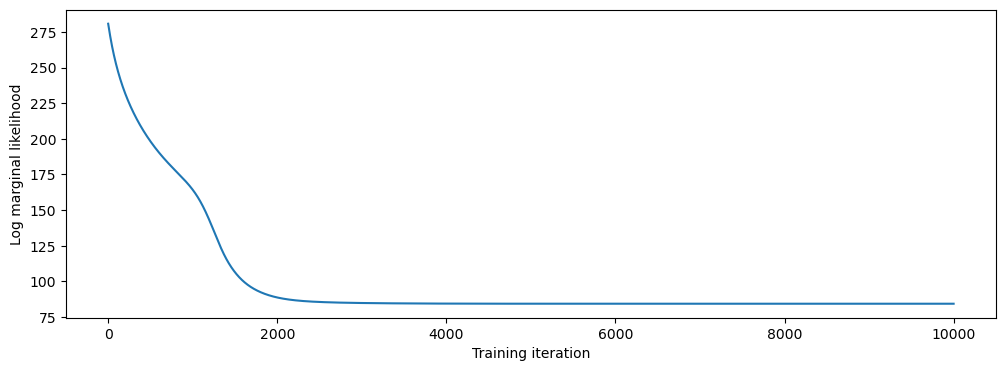

In [17]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [18]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(0, 1, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]


# HF kernel
optimized_kernel_0 = tfk.ExponentiatedQuadratic(amplitude_var_0, length_scale_var_0)
# LF kernel
optimized_kernel_1 = tfk.ExponentiatedQuadratic(amplitude_var_1, length_scale_var_1)

optimized_ar1_kernel = LinearMultiFidelityKernel(
    [optimized_kernel_0, optimized_kernel_1], [scale_parameter_var], name="AR1"
)

# Create the GP prior distribution, which we will use to train the model
# parameters.
ar1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_ar1_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var_0,
    predictive_noise_variance=np.float64(0.)
)


# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 100
samples = ar1_gprm.sample(num_samples)


h_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_0,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var_0,
    predictive_noise_variance=np.float64(0.)
)

h_samples = h_gprm.sample(num_samples)


Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


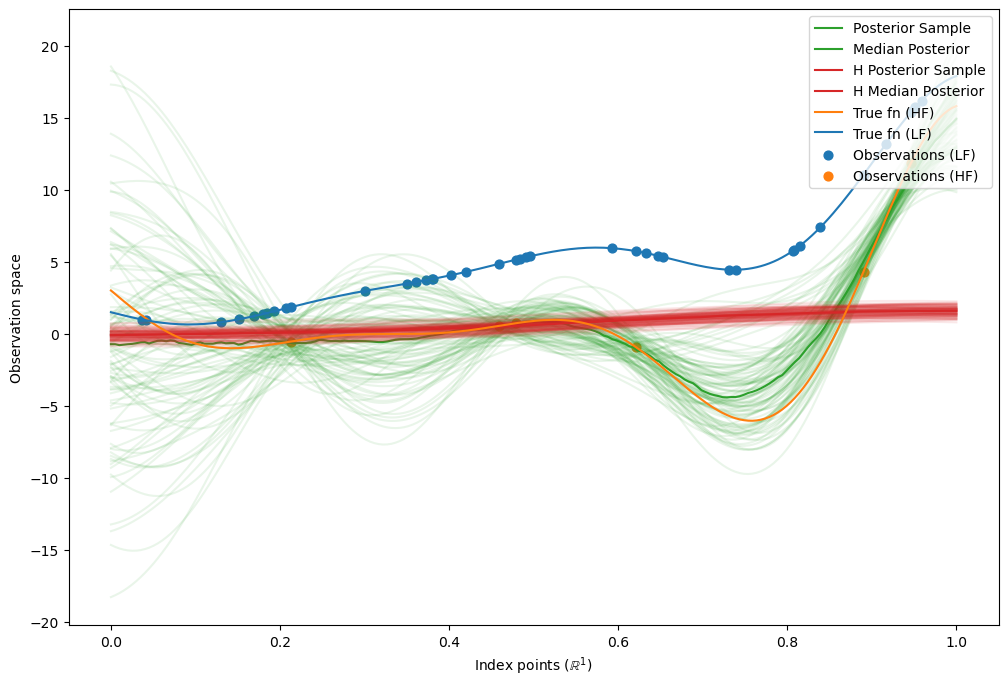

In [19]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

# AR1
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='C2', alpha=.1,
           label='Posterior Sample' if i == 0 else None)

plt.plot(predictive_index_points_, np.median(samples, axis=0), c='C2', label='Median Posterior')

# HF
for i in range(num_samples):
  plt.plot(predictive_index_points_, h_samples[i, :], c='C3', alpha=.1,
           label='H Posterior Sample' if i == 0 else None)

plt.plot(predictive_index_points_, np.median(h_samples, axis=0), c='C3', label='H Median Posterior')

plt.plot(x_plot, y_plot_h, label='True fn (HF)', color="C1")
plt.plot(x_plot, y_plot_l, label='True fn (LF)', color="C0")

plt.scatter(x_train_l, y_train_l, color='C0', s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color='C1', s=40, label="Observations (HF)")



leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

If you only train on HF data:

In [20]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=x_train_h,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(0.025)),
    'observations': build_gp,
})

# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables_hf_only = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]


def target_log_prob_hf_only(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': y_train_h[:, 0]
  })

# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob_hf_only(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables_hf_only)
  optimizer.apply_gradients(zip(grads, trainable_variables_hf_only))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss



# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# HF only kernel
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)

h_only_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=np.float64(0.)
)

h_only_samples = h_only_gprm.sample(num_samples)


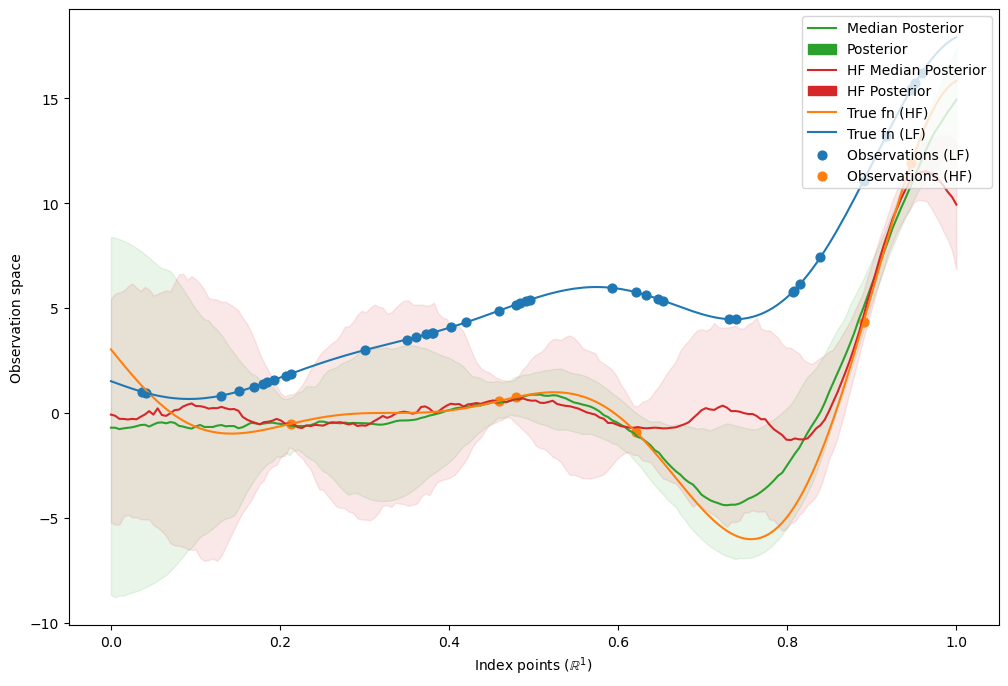

In [21]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

lower, median, upper = np.quantile(samples.numpy(), [0.1, 0.5, 0.9], axis=0)

# AR1
plt.plot(predictive_index_points_, median, c='C2', label='Median Posterior')
plt.fill_between(
  predictive_index_points_[:, 0],
  lower,
  upper,
  color="C2",
  alpha=0.1,
  label="Posterior",
)



lower_hf, median_hf, upper_hf = np.quantile(h_only_samples.numpy(), [0.1, 0.5, 0.9], axis=0)

# HF
plt.plot(predictive_index_points_, median_hf, c='C3', label='HF Median Posterior')
plt.fill_between(
  predictive_index_points_[:, 0],
  lower_hf,
  upper_hf,
  color="C3",
  alpha=0.1,
  label="HF Posterior",
)

plt.plot(x_plot, y_plot_h, label='True fn (HF)', color="C1")
plt.plot(x_plot, y_plot_l, label='True fn (LF)', color="C0")

plt.scatter(x_train_l, y_train_l, color='C0', s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color='C1', s=40, label="Observations (HF)")



leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## Marginalizing hyperparameters with HMC

Instead of optimizing the hyperparameters, let's try integrating them out with Hamiltonian Monte Carlo. We'll first define and run a sampler to approximately draw from the posterior distribution over kernel hyperparameters, given the observations.

In [22]:
num_results = 150
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        ]
    )

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [
    tf.cast(x, tf.float64) for x in [1., 1., 1., 1., 1., 1., 1.]
]

In [23]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 7.46s.


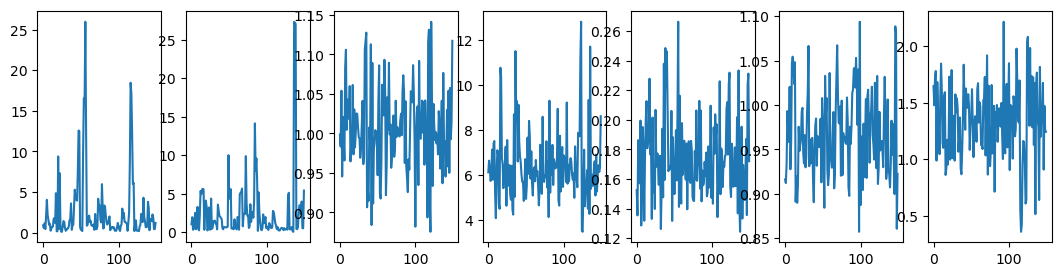

In [24]:
(
    amplitude_0_samples,
    length_scale_0_samples,
    observation_noise_variance_0_samples,
    amplitude_1_samples,
    length_scale_1_samples,
    observation_noise_variance_1_samples,
    scale_parameter_samples,
) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
  ax = f.add_subplot(1, len(samples) + 1, i + 1)
  ax.plot(s)

In [25]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.

# HF kernel
batch_kernel_0 = tfk.ExponentiatedQuadratic(
    amplitude_0_samples, length_scale_0_samples,
)
# LF kernel
batch_kernel_1 = tfk.ExponentiatedQuadratic(
    amplitude_1_samples,
    length_scale_1_samples,
)

batch_ar1_kernel = LinearMultiFidelityKernel(
    [batch_kernel_0, batch_kernel_1], [scale_parameter_samples], name="AR1"
)

# Create the GP prior distribution, which we will use to train the model
# parameters.
batch_ar1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_ar1_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_0_samples,
    predictive_noise_variance=np.float64(0.)
)


# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_ar1_gprm
)

num_samples = 100
hmc_samples = predictive_gprm.sample(num_samples)

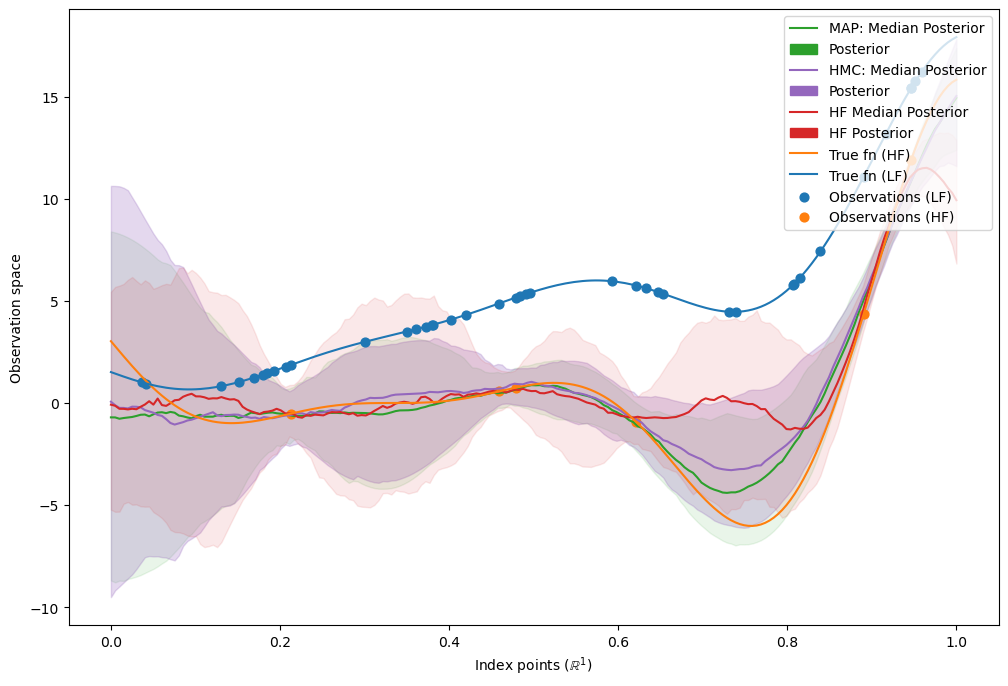

In [26]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

# lower, median, upper = np.quantile(samples.numpy(), [0.25, 0.5, 0.75], axis=0)

# AR1: MAP
plt.plot(predictive_index_points_, median, c='C2', label='MAP: Median Posterior')
plt.fill_between(
  predictive_index_points_[:, 0],
  lower,
  upper,
  color="C2",
  alpha=0.1,
  label="Posterior",
)

hmc_lower, hmc_median, hmc_upper = np.quantile(hmc_samples.numpy(), [0.1, 0.5, 0.9], axis=0)

# AR1: HMC
plt.plot(predictive_index_points_, hmc_median, c='C4', label='HMC: Median Posterior')
plt.fill_between(
  predictive_index_points_[:, 0],
  hmc_lower,
  hmc_upper,
  color="C4",
  alpha=0.25,
  label="Posterior",
)


lower_hf, median_hf, upper_hf = np.quantile(h_only_samples.numpy(), [0.1, 0.5, 0.9], axis=0)

# HF
plt.plot(predictive_index_points_, median_hf, c='C3', label='HF Median Posterior')
plt.fill_between(
  predictive_index_points_[:, 0],
  lower_hf,
  upper_hf,
  color="C3",
  alpha=0.1,
  label="HF Posterior",
)

plt.plot(x_plot, y_plot_h, label='True fn (HF)', color="C1")
plt.plot(x_plot, y_plot_l, label='True fn (LF)', color="C0")

plt.scatter(x_train_l, y_train_l, color='C0', s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color='C1', s=40, label="Observations (HF)")



leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()